<a href="https://colab.research.google.com/github/rickiepark/llm-from-scratch/blob/main/ch04/01_main-chapter-code/ch04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
세바스찬 라시카(Sebastian Raschka)가 쓴 <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a>의 번역서 예제 코드입니다.<br>
<br>코드 저장소: <a href="https://github.com/rickiepark/llm-from-scratch">https://github.com/rickiepark/llm-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 4장: 밑바닥부터 GPT 모델 구현하기

In [ ]:
from importlib.metadata import version

print("맷플롯립 버전:", version("matplotlib"))
print("파이토치 버전:", version("torch"))
print("tiktoken 버전:", version("tiktoken"))

matplotlib version: 3.10.0
torch version: 2.6.0
tiktoken version: 0.9.0


- 이 장에서 GPT와 유사한 LLM 구조를 구현합니다. 다음 장에서는 이 LLM 훈련하는데 초점을 맞추겠습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="650px">

## 4.1 구조 구현하기

- 1장은 GPT와 Llama 같은 모델을 소개했습니다. 이런 모델은 원본 트랜스포머 구조의 디코더 부분을 기반으로 순차적으로 단어를 생성합니다.
- 따라서 이런 LLM을 종종 디코더 기반 LLM이라 부릅니다.
- 전통적인 딥러닝 모델과 비교하면 LLM은 규모가 큽니다. 이는 코드의 양이 아니라 방대한 파라미터 개수 때문입니다.
- 앞으로 보겠지만 LLM 구조의 많은 구성 요소가 반복적입니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="600px">

- 이전 장에서 설명의 편의를 위해 토큰 입력과 출력의 임베딩 차원을 작게 했습니다.
- 이 장에서는 작은 GPT-2 모델와 같은 임베딩 크기를 사용합니다.
- 구체적으로 Radford et al.'s [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)에 나온 가장 작은 GPT-2 모델 구조(1억 2,400만 파라미터)를 구현하겠습니다(처음에는 1억 1,700만 파라미터라고 보고되었지만 나중에 모델 저장소에 수정된 값으로 공개되었습니다).
- 여기서 구현한 모델은 3억 4,500만 파라미터, 7억 6,200만 파라미터, 15억 4,200만 파라미터를 가진 모델과 호환됩니다. 6장에서 이 구현에 사전 훈련된 가중치를 로드하는 방법을 알아 보겠습니다.

- 1억 2,400만 파라미터 GPT-2 모델의 설정은 다음과 같습니다:

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # 어휘사전 크기
    "context_length": 1024, # 문맥 길이
    "emb_dim": 768,         # 임베딩 차원
    "n_heads": 12,          # 어텐션 헤드 개수
    "n_layers": 12,         # 층 개수
    "drop_rate": 0.1,       # 드롭아웃 비율
    "qkv_bias": False       # 쿼리, 키, 값을 만들 때 편향 포함 여부
}

- `"vocab_size"`는 BPE 토크나이저(2장 참조)에서 사용할 50,257 토큰으로 구성된 어휘 사전 크기를 나타냅니다.
- `"context_length"`는 위치 임베딩(2장 참조)으로 모델이 다룰 수 있는 입력 토큰의 최대 개수입니다.
- `"emb_dim"`은 임베딩 크기를 나타내며, 각 토큰을 768 차원의 벡터로 변환합니다.
- `"n_heads"`는 멀티 헤드 어텐션 메커니즘(3장 참조)에 있는 어텐션 헤드의 개수입니다.
- `"n_layers"`에는 모델에 있는 (이 장에서 소개할) 트랜스포머 블록의 개수를 지정합니다.
- `"drop_rate"`는 과대적합을 막기 위한 드롭아웃 메커니즘(3장 참조)의 강도를 지정합니다(0.1은 은닉 유닛의 10%를 랜덤하게 제외한다는 의미입니다).
- `"qkv_bias"`는 멀티 헤드 어텐션의 Linear 층에서 쿼리, 키, 값을 계산할 때 편향 유닛을 도입할지 여부를 결정합니다. 현대적인 LLM의 구성 방식을 따라서 처음에는 이 값을 비활성화하지만 오픈AI의 사전 훈련된 GPT-2 가중치를 모델로 로드할 때 이를 다시 살펴 보겠습니다(6장 참조).

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="650px">

In [ ]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 더미 클래스

    def forward(self, x):
        # 이 블록은 아무것도 하지 않고 입력을 그냥 반환합니다.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # 층 정규화 인터페이스를 흉내내기 위한 매개변수

    def forward(self, x):
        # 이 블록은 아무것도 하지 않고 입력을 그냥 반환합니다.
        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="650px">

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("출력 크기:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


---

**노트**

- 이 코드를 윈도나 리눅스에서 실행하면 결괏값이 다음처럼 보일 수 있습니다:
    
```
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
```

- 이는 난수 때문이며 문제가 되지 않으므로 이 장의 나머지 코드를 실행하는데 이슈가 없습니다.
- 이런 차이가 생기는 한 가지 이유는 `nn.Dropout`이 파이토치가 컴파일된 운영체제에 따라 다르게 동작하기 때문입니다. 자세한 내용은 [파이토치 이슈 트래커](https://github.com/pytorch/pytorch/issues/121595)를 참고하세요.

---

## 4.2 층 정규화로 활성화 정규화하기

- LayerNorm([Ba et al. 2016](https://arxiv.org/abs/1607.06450))이라고도 불리는 층 정규화는 신경망 층의 활성화를 평균이 0이고 분산이 1이 되도록 조정합니다.
- 이를 통해 훈련을 안정화하고 가중치 수렴 속도를 높일 수 있습니다.
- 나중에 구현하겠지만 층 정규화는 트랜스포머 블록의 멀티 헤드 어텐션 모듈 전후에 적용됩니다. 또한 최종 출력 층 전에도 적용됩니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="600px">

- 작은 입력 샘플을 간단한 신경망 층에 통과시켜 층 정규화의 작동 방식을 알아 보죠:

In [ ]:
torch.manual_seed(123)

# 다섯 개의 차원(특성)을 가진 두 개의 훈련 샘플을 만듭니다.
batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- 두 개의 입력에 대해 각각 평균과 분산을 계산해 보겠습니다:

In [ ]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("평균:\n", mean)
print("분산:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- 정규화는 두 입력(행)에 대해 독립적으로 적용됩니다. dim=-1을 사용하면 행 차원이 아니라 마지막 차원(이 경우 특성 차원)을 따라 계산이 수행됩니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="600px">

- 평균을 빼고, 분산의 제곱근(표준편차)으로 나누면 입력을 열(특성) 차원을 따라 평균이 0이고 분산이 1이 되도록 만듭니다:

In [ ]:
out_norm = (out - mean) / torch.sqrt(var)
print("정규화된 층 출력:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("평균:\n", mean)
print("분산:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 각 입력의 평균은 0이고 분산은 1입니다. 결과를 보기 쉽도록 파이토치의 과학적 표기법을 끌 수 있습니다:

In [ ]:
torch.set_printoptions(sci_mode=False)
print("평균:\n", mean)
print("분산:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 위에서 각 입력의 특성을 정규화했습니다.
- 이제 동일한 아이디어를 사용해 `LayerNorm` 클래스를 구현해 보죠:

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**스케일 조정과 이동**

- 평균을 빼고, 분산으로 나누어 정규화하는 것 이외에 두 개의 훈련 가능한 파라미터 `scale`과 `shift`를 추가했습니다.
- 초기 `scale`(1)과 `shift`(0)은 아무런 영향을 미치지 못합니다. 하지만 `scale`과 `shift`가 훈련 가능한 파라미터이기 때문에 훈련 과정에서 두 파라미터를 조정하는 것이 훈련 작업에서 모델의 성능을 향상시킨다고 판단하는 경우 LLM이 자동으로 조정합니다.
- 이를 통해 모델은 처리하는 데이터에 가잘 잘 맞는 스케일 조정과 이동을 학습할 수 있습니다.
- 분산의 제곱근을 계산할 때 작은 값(`eps`)를 더합니다. 이는 분산이 0일 경우 0 나눗셈 오류를 방지하기 위해서입니다.

**편향된 분산**
- 위 분산 계산에서 `unbiased=False`는 $\frac{\sum_i (x_i - \bar{x})^2}{n}$ 식으로 분산을 계산한다는 의미입니다. `n`은 샘플 크기입니다(여기서는 특성 또는 열 개수). 이 공식은 (분모가 `n-1`인) 베셀 보정(Bessel's correction)을 사용하지 않습니다. 따라서 편향된 분산을 추정합니다.
- LLM에서 임베딩 차원 `n`은 매우 크므로 `n`과 `n-1`을 사용하는 차이는 무시할 수 있습니다.
- 하지만 GPT-2가 정규화 층에 편향된 분산을 사용했으므로 나중에 사전 훈련된 가중치를 로드할 때 호환성을 위해 동일한 방식을 적용했습니다.
- 이제 `LayerNorm`을 실제로 테스트해 보죠:

In [ ]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [ ]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("평균:\n", mean)
print("분산:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="600px">

## 4.3 GELU 활성화 함수를 사용하는 피드 포워드 네트워크 구현하기

- 이 절에서 LLM의 트랜스포머 블록에서 사용되는 작은 신경망 모듈을 구현합니다.
- 딥러닝에서는 ReLU(Rectified Linear Unit) 활성화 함수가 간단하며 다양한 신경망 구조에서 효과적이기 때문에 널리 사용됩니다.
- LLM에서는 전통적인 ReLU 외에도 다양한 종류의 활성화 함수가 사용됩니다. 대표적인 두 개의 함수는 GELU(Gaussian Error Linear Unit)와 SwiGLU(Swish-Gated Linear Unit)입니다.
- GELU와 SwiGLU는 각각 가우스 오차 함수와 시그모이드 GLU(gated linear unit)을 사용한 더 복잡하고 부드러운 활성화 함수입니다. 간단한 ReLU와 달리 딥러닝 모델의 성능을 향상시킵니다.

- GELU 활성화 함수([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415))는 여러 방법으로 구현할 수 있습니다. 정확한 정의는 GELU(x) = x⋅𝛷(x)입니다. 여기서 𝛷(x)는 표준 가우스 누적 분포 함수(가우스 오차 함수)입니다.
- 실제로는 계산하기 쉬운 근사식으로 구현합니다: $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$ (원본 GPT-2 모델도 커브 피팅(curve fitting)으로 찾은 이 근사식을 사용했습니다).

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

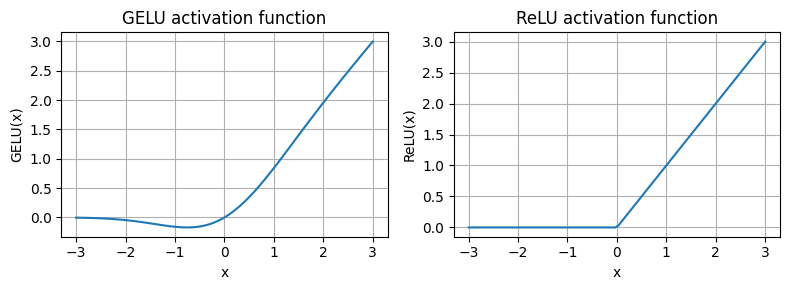

In [ ]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# 샘플 데이터
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- 여기서 보듯이 ReLU는 양수는 그대로 출력하고 음수는 모두 0을 출력하는 구간별 선형 함수(piecewise linear function)입니다.
- GELU는 부드러운 비선형 함수로, ReLU와 비슷하지만 모든 음수 값의 그레이디언트를 0으로 만들지 않습니다(대략 x = -0.75에서는 그레이디언트가 0이 됩니다).
- 그다음 LLM의 트랜스포머 블록에 사용할 작은 신경망 모듈인 `FeedForward`를 구현해 보죠:

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="600px">

In [ ]:
ffn = FeedForward(GPT_CONFIG_124M)

# 입력 크기: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="600px">

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="600px">

## 4.4 숏컷 연결 추가하기

- 스킵 연결(skip connection)이나 잔차 연결(residual connection)이라고도 부르는 숏컷 연결(shortcut connection) 이면의 개념을 알아 보죠.
- 원래 숏컷 연결은 컴퓨터 비전 분야의 심층 신경망(구체적으로 잔차 신경망(residual network))에서 그레이디언트 소실 문제를 완화하기 위해 제안되었습니다.
- 숏컷 연결이 그레이디언트가 한 개 이상의 층을 건너 뛰어 네트워크에 흐를 수 있도록 짧은 다른 경로를 만든다는 것을 보여줍니다.
- 이런 경로는 한 층의 출력을 이후 층의 출력에 더하여 만들어집니다.
- 작은 샘플 네트워크로 이 아이디어를 설명해 보죠:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="600px">

- 코드로 구현하면 다음과 같습니다:

In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- Let's print the gradient values first **without** shortcut connections:

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152039906941354
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


- Next, let's print the gradient values **with** shortcut connections:

In [ ]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


- As we can see based on the output above, shortcut connections prevent the gradients from vanishing in the early layers (towards `layer.0`)
- We will use this concept of a shortcut connection next when we implement a transformer block

## 4.5 Connecting attention and linear layers in a transformer block

- In this section, we now combine the previous concepts into a so-called transformer block
- A transformer block combines the causal multi-head attention module from the previous chapter with the linear layers, the feed forward neural network we implemented in an earlier section
- In addition, the transformer block also uses dropout and shortcut connections

In [ ]:
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch03 import MultiHeadAttention

from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="400px">

- Suppose we have 2 input samples with 6 tokens each, where each token is a 768-dimensional embedding vector; then this transformer block applies self-attention, followed by linear layers, to produce an output of similar size
- You can think of the output as an augmented version of the context vectors we discussed in the previous chapter

In [ ]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="400px">

## 4.6 Coding the GPT model

- We are almost there: now let's plug in the transformer block into the architecture we coded at the very beginning of this chapter so that we obtain a usable GPT architecture
- Note that the transformer block is repeated multiple times; in the case of the smallest 124M GPT-2 model, we repeat it 12 times:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="400px">

- The corresponding code implementation, where `cfg["n_layers"] = 12`:

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- Using the configuration of the 124M parameter model, we can now instantiate this GPT model with random initial weights as follows:

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


- We will train this model in the next chapter
- However, a quick note about its size: we previously referred to it as a 124M parameter model; we can double check this number as follows:

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- As we see above, this model has 163M, not 124M parameters; why?
- In the original GPT-2 paper, the researchers applied weight tying, which means that they reused the token embedding layer (`tok_emb`) as the output layer, which means setting `self.out_head.weight = self.tok_emb.weight`
- The token embedding layer projects the 50,257-dimensional one-hot encoded input tokens to a 768-dimensional embedding representation
- The output layer projects 768-dimensional embeddings back into a 50,257-dimensional representation so that we can convert these back into words (more about that in the next section)
- So, the embedding and output layer have the same number of weight parameters, as we can see based on the shape of their weight matrices
- However, a quick note about its size: we previously referred to it as a 124M parameter model; we can double check this number as follows:

In [ ]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- In the original GPT-2 paper, the researchers reused the token embedding matrix as an output matrix
- Correspondingly, if we subtracted the number of parameters of the output layer, we'd get a 124M parameter model:

In [ ]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


- In practice, I found it easier to train the model without weight-tying, which is why we didn't implement it here
- However, we will revisit and apply this weight-tying idea later when we load the pretrained weights in chapter 5
- Lastly, we can compute the memory requirements of the model as follows, which can be a helpful reference point:

In [ ]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


- Exercise: you can try the following other configurations, which are referenced in the [GPT-2 paper](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dOad5HoAAAAJ&citation_for_view=dOad5HoAAAAJ:YsMSGLbcyi4C), as well.

    - **GPT2-small** (the 124M configuration we already implemented):
        - "emb_dim" = 768
        - "n_layers" = 12
        - "n_heads" = 12

    - **GPT2-medium:**
        - "emb_dim" = 1024
        - "n_layers" = 24
        - "n_heads" = 16
    
    - **GPT2-large:**
        - "emb_dim" = 1280
        - "n_layers" = 36
        - "n_heads" = 20
    
    - **GPT2-XL:**
        - "emb_dim" = 1600
        - "n_layers" = 48
        - "n_heads" = 25

## 4.7 Generating text

- LLMs like the GPT model we implemented above are used to generate one word at a time

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="400px">

- The following `generate_text_simple` function implements greedy decoding, which is a simple and fast method to generate text
- In greedy decoding, at each step, the model chooses the word (or token) with the highest probability as its next output (the highest logit corresponds to the highest probability, so we technically wouldn't even have to compute the softmax function explicitly)
- In the next chapter, we will implement a more advanced `generate_text` function
- The figure below depicts how the GPT model, given an input context, generates the next word token

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="600px">

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

- The `generate_text_simple` above implements an iterative process, where it creates one token at a time

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="600px">

- Let's prepare an input example:

In [ ]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


- Remove batch dimension and convert back into text:

In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- Note that the model is untrained; hence the random output texts above
- We will train the model in the next chapter

## Summary and takeaways

- See the [./gpt.py](./gpt.py) script, a self-contained script containing the GPT model we implement in this Jupyter notebook
- You can find the exercise solutions in [./exercise-solutions.ipynb](./exercise-solutions.ipynb)